# Jobflow hands-on

Jobflow is a free, open-source library for writing and executing workflows. Complex workflows can be defined using simple python functions and executed **locally** or on arbitrary computing resources using the [jobflow-remote](https://matgenix.github.io/jobflow-remote/) or [FireWorks](https://materialsproject.github.io/fireworks/) workflow managers.

In this hands-on, we will only execute the workflows locally. In subsequent sessions, jobflow-remote will be presented and used for the execution of the workflows.

Topics covered in this session:
- The @job decorator and the Job object
- Local execution with run_locally
- Creating flows
- Dynamic workflows
- Concept of Makers

In addition to these general topics, a series of <font color="green">**DO**</font>'s and <font color="red">**DONT**</font>'s or common errors will be (on purpose) shown in this session.

## The @job decorator and the Job object

Let's define a (very) simple function that adds two numbers:

In [1]:
def add(a, b):
    return a+b

result = add(2, 5)
print(result)

7


The output is simply the sum of the two numbers. Now let's use the @job decorator for this function:

In [2]:
from jobflow import job

@job
def add(a, b):
    return a+b

add_job = add(2, 5)
print(add_job)

Job(name='add', uuid='43a2d3c4-460e-4e5b-aca9-12e338d6f505')


/home/jgeorge/miniconda3/envs/2025-bam-jobflow-tutorial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The function add now return a Job object. The sum of the two numbers has not yet been executed. The execution is deferred to a later time, i.e. either when we execute it locally or when a workflow manager executes it (after its submission). The deferred output can be accessed through the output attribute of the job. This output attribute contains an OutputReference, which is a "link" to the job output (or an attribute, item, subitem, ... of this output - more about this later!).

A Job object has a unique identifier (uuid) and an index. The uuid is automatically assigned when the job is created. The index is by default 1 when the job is first created. We will see later on when (as well as why and how) this index can change.

In [3]:
print(add_job.uuid)   # This uniquely identifies a Job
print(add_job.index)  # This is the index of a given Job (two or more jobs can have the same uuid but different - increasing - index's)
print(add_job.output) # OutputReference - Link to this job output

43a2d3c4-460e-4e5b-aca9-12e338d6f505
1
OutputReference(43a2d3c4-460e-4e5b-aca9-12e338d6f505)


<font color="red">**DONT**</font> Be careful with namespaces. Users might be tempted here to name the resulting job as "job":

In [4]:
job = add(5, 10)

Now you can't decorate another function because "job" has been redefined...

In [5]:
@job
def somefunction(x):
    return x

TypeError: 'Job' object is not callable

## Local execution with run_locally
Let's now reimport job here and recreate some jobs to be executed!

In [6]:
from jobflow import job, run_locally

@job
def add(a, b):
    return a+b

Let's create one job and run it locally!

In [7]:
add_job = add(2, 3)
output = run_locally(add_job)

2025-07-11 08:30:30,999 INFO Started executing jobs locally
2025-07-11 08:30:31,359 INFO Starting job - add (01c15117-d972-4458-b4ce-c167b7f0783a)
2025-07-11 08:30:31,362 INFO Finished job - add (01c15117-d972-4458-b4ce-c167b7f0783a)
2025-07-11 08:30:31,362 INFO Finished executing jobs locally


We some logging about the job starting and finishing.

And now look at the output. We are using pprint here to get a nicely printed output.

In [8]:
import pprint
pprint.pprint(output)

{'01c15117-d972-4458-b4ce-c167b7f0783a': {1: Response(output=5,
                                                      detour=None,
                                                      addition=None,
                                                      replace=None,
                                                      stored_data=None,
                                                      stop_children=False,
                                                      stop_jobflow=False,
                                                      job_dir=PosixPath('/smb/jgeorge/hpc-user/PycharmProjects/2025-bam-jobflow-tutorial/BAM-jobflow-tutorial'))}}


What do we have in here ?
- A dictionary with the uuid of the job as a key
- The value for that key is another dictionary
- This other dictionary has the index of the job as a key
- The value for that index key is a Response object
- The Response object contains
  - The output of the original add function (i.e. the sum of the two numbers - here 2 + 3 = ... drumroll ... 5)
  - Other stuff (see later)

<font color="red">**DONT**</font> run the same job twice.

In [9]:
run_locally(add_job)

ValueError: Job add (01c15117-d972-4458-b4ce-c167b7f0783a) already belongs to another flow.

The above error seems quite cryptic, we will see why this happens later but in any case this happens because we tried to run this add_job twice.

Where do the jobs run ? Let's see with another example:

In [10]:
from pathlib import Path

@job
def hello(name):
    """This job writes a hello.txt file with Hello + the name."""
    Path('hello.txt').write_text(f'Hello {name}')

hello_david = hello('David')
hello_john = hello('John')

run_locally(hello_david)
run_locally(hello_john)
    

2025-07-11 08:30:50,454 INFO Started executing jobs locally
2025-07-11 08:30:50,455 INFO Starting job - hello (4b1850e7-56ab-4210-9eaa-abeb277cc236)
2025-07-11 08:30:50,462 INFO Finished job - hello (4b1850e7-56ab-4210-9eaa-abeb277cc236)
2025-07-11 08:30:50,462 INFO Finished executing jobs locally
2025-07-11 08:30:50,463 INFO Started executing jobs locally
2025-07-11 08:30:50,464 INFO Starting job - hello (e7af5b8a-4756-4259-8954-f7157bab8225)
2025-07-11 08:30:50,469 INFO Finished job - hello (e7af5b8a-4756-4259-8954-f7157bab8225)
2025-07-11 08:30:50,470 INFO Finished executing jobs locally


{'e7af5b8a-4756-4259-8954-f7157bab8225': {1: Response(output=None, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/smb/jgeorge/hpc-user/PycharmProjects/2025-bam-jobflow-tutorial/BAM-jobflow-tutorial'))}}

In [9]:
!ls
!cat hello.txt

handson_jobflow.ipynb  hello.txt  LICENSE  README.md  requirements.txt
Hello John

The jobs have run in same directory (the current directory) and the second job ("hello_john") has overwritten the file produced by the first one.

<font color="green">**DO**</font> use create_folders=True in run_locally. This will create one folder for each job so that there is no clash of outputs and no lost data. Note that this is of course important when jobs create files (which is almost always the case) but in some cases, they do not, as in the example above with the *add* job function.

In [ ]:
hello_david = hello('David')
hello_john = hello('John')

run_locally(hello_david, create_folders=True)
run_locally(hello_john, create_folders=True)
    

In [ ]:
!ls
!cat hello.txt

You can look inside the two *job_2025-**** directories to see what's in there.

Note that when you will start using Jobflow-Remote as a manager instead of the local manager (i.e. run_locally), you don't need to set anything like that as all job directories are automatically created by Jobflow-Remote. The local manager is very useful for training, testing, verifying, developing but once you are in production, you should use Jobflow-Remote.

## Creating Flows
Flows are created easily from a list of jobs and/or flows.
The dependencies between the different jobs and flows are automatically defined from the *OutputReference* links (output attributes of other jobs in arguments of a given job).
The graph of jobs in a Flow can easily be visualized with matplotlib using the *draw_graph* method of the flow.

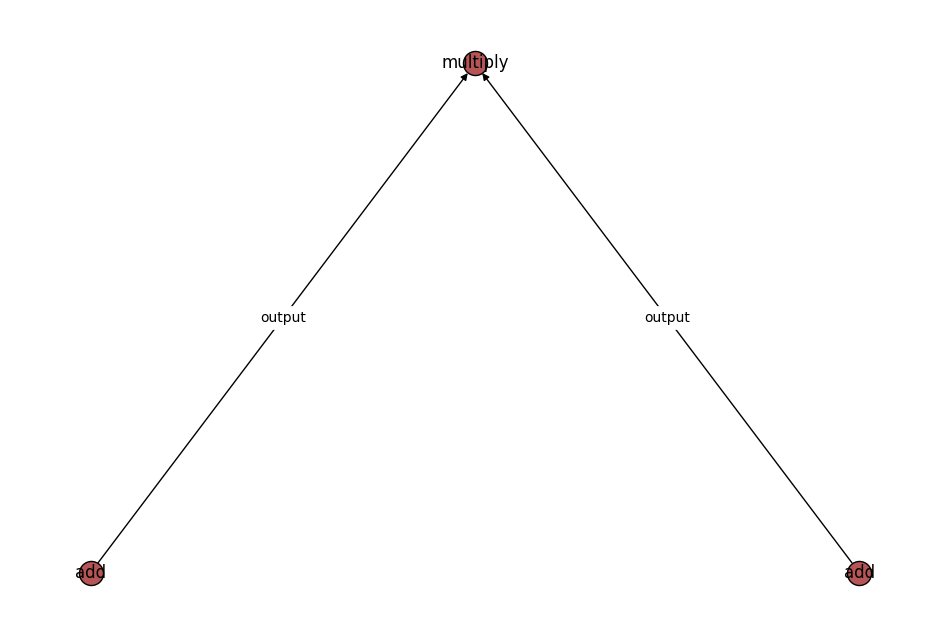

In [11]:
from jobflow import Flow

@job
def add(a, b):
    return a+b

@job
def multiply(a, b):
    return a*b


add_job1 = add(2, 3)
add_job2 = add(3, 5)
multiply_job = multiply(add_job1.output, add_job2.output)

myflow = Flow([add_job1, add_job2, multiply_job])

myflow.draw_graph().show()

Alternatively, you can also visualize the graph using mermaid. Generate the mermaid syntax using the *to_mermaid* function and paste the output on [Mermaid Live](https://mermaid.live/).

In [12]:
from jobflow.utils.graph import to_mermaid
print(to_mermaid(myflow))

flowchart TD
    8d696257-f0f4-4df2-9ad1-3f1a80424d9f(add) -->|output| 30971040-0506-470d-ad6b-b7b804cb9cfb(multiply)
    5a6c7b9b-6e16-49ee-b278-34b7c2707612(add) -->|output| 30971040-0506-470d-ad6b-b7b804cb9cfb(multiply)
    8d696257-f0f4-4df2-9ad1-3f1a80424d9f(add)
    5a6c7b9b-6e16-49ee-b278-34b7c2707612(add)
    30971040-0506-470d-ad6b-b7b804cb9cfb(multiply)


Let's run this flow now!

In [13]:
outputs = run_locally(myflow, create_folders=True)
pprint.pprint(outputs)

2025-07-11 08:31:21,528 INFO Started executing jobs locally
2025-07-11 08:31:21,532 INFO Starting job - add (8d696257-f0f4-4df2-9ad1-3f1a80424d9f)
2025-07-11 08:31:21,533 INFO Finished job - add (8d696257-f0f4-4df2-9ad1-3f1a80424d9f)
2025-07-11 08:31:21,536 INFO Starting job - add (5a6c7b9b-6e16-49ee-b278-34b7c2707612)
2025-07-11 08:31:21,537 INFO Finished job - add (5a6c7b9b-6e16-49ee-b278-34b7c2707612)
2025-07-11 08:31:21,540 INFO Starting job - multiply (30971040-0506-470d-ad6b-b7b804cb9cfb)
2025-07-11 08:31:21,541 INFO Finished job - multiply (30971040-0506-470d-ad6b-b7b804cb9cfb)
2025-07-11 08:31:21,542 INFO Finished executing jobs locally
{'30971040-0506-470d-ad6b-b7b804cb9cfb': {1: Response(output=40,
                                                      detour=None,
                                                      addition=None,
                                                      replace=None,
                                                      stored_data=None,
      

As for the case of running single jobs, we see some logging of the jobs being executed. They are (of course ...) being executed in the correct order, i.e. multiply can only be executed after the two add jobs have finished.

Try to figure out what is the final result here.

## Dynamic workflows

Jobs can create other jobs (and flows). This is done by using the *Response* object as a returned value of a job instead of "just" its output. In addition to an *output* argument (which should contain the output of the job), the *Response* object has other arguments used for dealing with dynamic updates of the Flow:
- detour
- addition
- replace
- ...

Here we will give an example of using an *addition* or a *replace* for calculating the Fibonacci series. The Fibonacci series is a sequence of numbers where each number is the sum of the two preceding ones. It starts with 0 and 1, and the sequence goes like this:

    0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, ...

The following code allows to print the Fibonacci series with a recursion method:

In [14]:
def fibonacci(smaller, larger, maximum=50):
    total = smaller + larger
    if total > maximum:
        print(total)
        return

    print(f'{total}, ', end="")
    return fibonacci(larger, total, maximum=maximum)

fibonacci(0, 1)

1, 2, 3, 5, 8, 13, 21, 34, 55


Now let's adapt this to use a dynamic flow to compute the series of numbers:

In [15]:
from jobflow import Response

@job
def fibonacci(smaller, larger, maximum=50):
    total = smaller + larger
    if total > maximum:
        return total

    new_job = fibonacci(larger, total, maximum=maximum)
    return Response(output=total, addition=new_job)

fibonacci_job = fibonacci(0, 1)
outputs = run_locally(fibonacci_job)

2025-07-11 08:32:16,950 INFO Started executing jobs locally
2025-07-11 08:32:16,951 INFO Starting job - fibonacci (df3f297b-ee9b-42b9-9c59-df6f5e0f00af)
2025-07-11 08:32:16,952 INFO Finished job - fibonacci (df3f297b-ee9b-42b9-9c59-df6f5e0f00af)
2025-07-11 08:32:16,953 INFO Starting job - fibonacci (d930af3f-a3f9-4f75-8fcd-cfbcd124e99a)
2025-07-11 08:32:16,954 INFO Finished job - fibonacci (d930af3f-a3f9-4f75-8fcd-cfbcd124e99a)
2025-07-11 08:32:16,955 INFO Starting job - fibonacci (5163bb5f-e951-4715-9d52-ed8a93d84402)
2025-07-11 08:32:16,957 INFO Finished job - fibonacci (5163bb5f-e951-4715-9d52-ed8a93d84402)
2025-07-11 08:32:16,958 INFO Starting job - fibonacci (e24d6f75-deff-4d73-85f1-d2e6e3c15207)
2025-07-11 08:32:16,959 INFO Finished job - fibonacci (e24d6f75-deff-4d73-85f1-d2e6e3c15207)
2025-07-11 08:32:16,960 INFO Starting job - fibonacci (abf96f75-99ee-432d-99d6-9610552d8520)
2025-07-11 08:32:16,961 INFO Finished job - fibonacci (abf96f75-99ee-432d-99d6-9610552d8520)
2025-07-11

Although there was only one job at the beginning, multiple jobs have been executed. Let's look at the outputs:

In [16]:
pprint.pprint(outputs)

{'50532ee4-62de-4ee4-8314-a88f5f4aeda6': {1: Response(output=13,
                                                      detour=None,
                                                      addition=Flow(name='Flow', uuid='ccc9bef8-e63a-4879-9b3b-3c2b137cfe30')
1. Job(name='fibonacci', uuid='b9165194-b716-4a18-af4e-a58038759c15'),
                                                      replace=None,
                                                      stored_data=None,
                                                      stop_children=False,
                                                      stop_jobflow=False,
                                                      job_dir=PosixPath('/smb/jgeorge/hpc-user/PycharmProjects/2025-bam-jobflow-tutorial/BAM-jobflow-tutorial'))},
 '5163bb5f-e951-4715-9d52-ed8a93d84402': {1: Response(output=3,
                                                      detour=None,
                                                      addition=Flow(name='Flow', uuid='9

Difficult to know the order of the jobs and get back the series... Each job that sums two numbers has its own uuid and these are not ordered. Let's modify things a bit:

In [17]:
from jobflow import Response

@job
def fibonacci(smaller, larger, index=0, maximum=50):
    total = smaller + larger
    if total > maximum:
        return {"index": index, "number": total}

    new_job = fibonacci(larger, total, index=index+1, maximum=maximum)
    return Response(output={"index": index, "number": total}, addition=new_job)

fibonacci_job = fibonacci(0, 1)
outputs = run_locally(fibonacci_job)
pprint.pprint(outputs)

2025-07-11 08:34:07,058 INFO Started executing jobs locally
2025-07-11 08:34:07,059 INFO Starting job - fibonacci (52e95c28-8ec4-40de-a892-e4f2c4aa423a)
2025-07-11 08:34:07,060 INFO Finished job - fibonacci (52e95c28-8ec4-40de-a892-e4f2c4aa423a)
2025-07-11 08:34:07,061 INFO Starting job - fibonacci (6b72c6f8-bb9d-449b-a161-ad86c98e867d)
2025-07-11 08:34:07,063 INFO Finished job - fibonacci (6b72c6f8-bb9d-449b-a161-ad86c98e867d)
2025-07-11 08:34:07,064 INFO Starting job - fibonacci (5c67d72c-36af-441b-bb6c-2d3c22a9e1b7)
2025-07-11 08:34:07,065 INFO Finished job - fibonacci (5c67d72c-36af-441b-bb6c-2d3c22a9e1b7)
2025-07-11 08:34:07,066 INFO Starting job - fibonacci (57f3ded3-ed9d-4460-8dbd-e3c4fc2b699f)
2025-07-11 08:34:07,067 INFO Finished job - fibonacci (57f3ded3-ed9d-4460-8dbd-e3c4fc2b699f)
2025-07-11 08:34:07,068 INFO Starting job - fibonacci (da8ecad0-9fd2-4117-91a3-c5232b076abd)
2025-07-11 08:34:07,069 INFO Finished job - fibonacci (da8ecad0-9fd2-4117-91a3-c5232b076abd)
2025-07-11

Now at least we can go through it in an ordered manner:

In [18]:
for jobs_with_same_uuid in sorted(outputs.items(), key=lambda kv: kv[1][1].output['index']):
    print(jobs_with_same_uuid[1][1].output['number'])

1
2
3
5
8
13
21
34
55


Instead of using an *addition*, we can also use a *replace*, and now the index of the jobs increases but all jobs have the same uuid.

In [19]:
from jobflow import Response

@job
def fibonacci(smaller, larger, maximum=50):
    total = smaller + larger
    if total > maximum:
        return total

    new_job = fibonacci(larger, total, maximum=maximum)
    return Response(output=total, replace=new_job)

fibonacci_job = fibonacci(0, 1)
outputs = run_locally(fibonacci_job)
pprint.pprint(outputs)

2025-07-11 08:34:34,706 INFO Started executing jobs locally
2025-07-11 08:34:34,708 INFO Starting job - fibonacci (b9166c54-c5b9-401f-a3ea-5cda43983f8d)
2025-07-11 08:34:34,709 INFO Finished job - fibonacci (b9166c54-c5b9-401f-a3ea-5cda43983f8d)
2025-07-11 08:34:34,709 INFO Starting job - fibonacci (b9166c54-c5b9-401f-a3ea-5cda43983f8d, 2)
2025-07-11 08:34:34,710 INFO Finished job - fibonacci (b9166c54-c5b9-401f-a3ea-5cda43983f8d, 2)
2025-07-11 08:34:34,711 INFO Starting job - fibonacci (b9166c54-c5b9-401f-a3ea-5cda43983f8d, 3)
2025-07-11 08:34:34,711 INFO Finished job - fibonacci (b9166c54-c5b9-401f-a3ea-5cda43983f8d, 3)
2025-07-11 08:34:34,712 INFO Starting job - fibonacci (b9166c54-c5b9-401f-a3ea-5cda43983f8d, 4)
2025-07-11 08:34:34,713 INFO Finished job - fibonacci (b9166c54-c5b9-401f-a3ea-5cda43983f8d, 4)
2025-07-11 08:34:34,713 INFO Starting job - fibonacci (b9166c54-c5b9-401f-a3ea-5cda43983f8d, 5)
2025-07-11 08:34:34,715 INFO Finished job - fibonacci (b9166c54-c5b9-401f-a3ea-5cd

## The concept of Makers

The general concept of Makers in jobflow is to define "global" or "general" parameters of the procedure/flow/workflow that will be applied to all the calculations and separate these from the specific parameters for each calculation. For example, you might consider that the accuracy, the k-point density and the exchange-correlation functional are general parameters, while the structure, the charge, maybe some atoms or cells constraints are specific parameters. This concept is very important and allows to ensure reproducibility of calculations. You can share makers (makers are *serializable* and can be dumped as a json file) with other users/colleagues so that everyone uses the exact same general parameters.

Let's look at this concept for a very simplified toy example. Let's define "something" that increments a number. The goal is to have a job that, when given a number, will increment this number by a given amount and return the result. You could imagine that the increment amount is a general parameter (i.e. everytime you pass a number, you want to increment it by 10), and the number itself is the specific parameter.

In [ ]:
from dataclasses import dataclass
from jobflow import Maker

@dataclass
class IncrementMaker(Maker):
    name: str = "increment"
    increment: int = 1

    @job
    def make(self, number):
        return number + self.increment

Now you can initialize this increment maker (with the default value of 1 for the increment) and generate different jobs with it.

In [ ]:
increment_maker_1 = IncrementMaker()  # Will use the default value of 1 for the increment
job1 = increment_maker_1.make(5)      # Will be incremented by 1 => 6
job2 = increment_maker_1.make(12)      # Will be incremented by 1 => 13
job3 = increment_maker_1.make(500)      # Will be incremented by 1 => 501

pprint.pprint(run_locally(job1))
pprint.pprint(run_locally(job2))
pprint.pprint(run_locally(job3))

We can initialize the maker with a different value for the increment amount:

In [ ]:
increment_maker_5 = IncrementMaker(increment=5)  # Will use the default value of 1 for the increment
job1 = increment_maker_5.make(5)        # Will be incremented by 5 => 10
job2 = increment_maker_5.make(12)       # Will be incremented by 5 => 17
job3 = increment_maker_5.make(500)      # Will be incremented by 5 => 505

pprint.pprint(run_locally(job1))
pprint.pprint(run_locally(job2))
pprint.pprint(run_locally(job3))

You can pretty print makers:

In [ ]:
print(increment_maker_1)
print(increment_maker_5)

You can easily dump these makers to a json file and share them with colleagues (or store them for later reuse). Note here that this will work if the implemented maker is importable! If you implement a Maker in a script and serialize/dump it to a file, it can only be recreated if the actual Maker code is also importable on the machine where you would deserialize it. Within this notebook session, this will work as the code is still in memory but when you use Jobflow-Remote, this won't work anymore! It will of course work for atomate2 Makers as these are importable both locally (i.e. within this notebook) and anywhere else you would have atomate2 installed. \[see Jobflow-Remote and atomate2 hands-ons for more details\]

For convenience, we use *dumpfn* from the *monty* package to do so:

In [ ]:
from monty.serialization import dumpfn

dumpfn(increment_maker_1, 'maker_1.json', indent=2)  # here we use indent=2 to have a json file that is pretty printed
dumpfn(increment_maker_5, 'maker_5.json', indent=2)  # here we use indent=2 to have a json file that is pretty printed

You can look at the generated files to see what's in there.

Let's deserialize one of them (we use the *loadfn* helper function from *monty* for that) and recreate a few jobs:

In [ ]:
from monty.serialization import loadfn

some_maker = loadfn('maker_5.json')
job1 = some_maker.make(15)
job2 = some_maker.make(30)

pprint.pprint(run_locally(job1))
pprint.pprint(run_locally(job2))

## Accessing results using queries

Until now, the default store has been used for run_locally, i.e. a MemoryStore. Once run_locally has finished its execution, it does not exist anymore and you can't access the results anymore (unless you have assigned to an outputs variable for example). Now we will use a predefined store for running some calculations and see how we can access the outputs programmatically directly from the database.

First, we initialize the JobStore. A pre-configured store can be instantiated from a file. Note that this is only used in this first hands-on. Please note that in subsequent hands-ons and in production, the store is defined in the jobflow-remote config directly and we strongly advice you to use such a setup for production.

In [ ]:
from jobflow import JobStore
store = JobStore.from_file('config/my_store.yaml')

# Must connect to the store before being able to use
store.connect()
# Let's erase the database first (comment if you want to keep)
store.remove_docs({})

Let's recreate a fibonnacci job and run it locally with this store.

In [ ]:
fibonacci_job = fibonacci(0, 1)
run_locally(fibonacci_job, store=store)

Now we can get the outputs directly from that store. We can see how many job outputs are stored. Let's also have a look at one (random) output.

In [ ]:
print(store.count())
pprint.pprint(store.query_one())

We can get all the numbers from the fibonacci series:

In [ ]:
for doc in store.query():
    print(doc['output'])

Let's make another double add and multiply flow as in the beginning of this session:

In [ ]:
add_job1 = add(1, 2)
add_job2 = add(3, 3)
multiply_job = multiply(add_job1.output, add_job2.output)

myflow = Flow([add_job1, add_job2, multiply_job])
run_locally(myflow, store=store)

Now the three outputs are in the store as well. We can get the result of the multiply job with a query.

In [ ]:
print(store.count())
print("Result of the multiplication: ", store.query_one({"name": "multiply"})["output"])